#Data Review

A high level review of data structure is contained within this notebook.

Link to Google Drive, load libraries and reference source code.

In [1]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/MyDrive/CSC8635/
## Check that the data_subjects_info.csv is in the current folder location
#@title
## set up the libraries that are needed to run the analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Code based on: https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data

Mounted at /gdrive
/gdrive
/gdrive/MyDrive/CSC8635


Load data (see IMPORTANT reference to adjust to your filepath)

In [2]:
#@title
#set up for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 samples frames , each one will be a different experiment
Segment_Size = 400

# Activity types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
  Csv = glob(j + '/*' )
  for i in Csv:
    df = pd.read_csv(i)
    df['Activity'] = activity_codes[j[40:43]] #IMPORTANT: this index is selecting the three letter reference for activity from your filepath
    df['Sub_Num'] = i[len(j)+5:-4]
    df['Exp_num'] = 1
    ExpNum = np.zeros((df.shape[0])) 
    for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
      ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
    df['Exp_num'] = ExpNum
    #Df_all = pd.concat([Df_all,df])
    Df_all_list.append(df)
    Exp += 1        
Df_all = pd.concat(Df_all_list,axis=0)  
print(f'The data has been loaded.')
print(f'The dimensions of the complete dataset are {Df_all.shape}.')
print(f'The 16 column headers are {Df_all.columns}.')
#check unique values for the participants
#np.unique(Df_all['Sub_Num'])

The data has been loaded.
The dimensions of the complete dataset are (1412865, 16).
The 16 column headers are Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object').


Some participants completed more activities, and some trials took longer than others. Therefore the data is not balanced across activity types, with larger datasets for sitting and walking. The smallest datasets were for jogging and going downstairs. Looking at first time series data records, 'dws', 'ups', 'wlk' are similar to each other, 'sit' and 'std' are similar, and 'jog' is distinctive from the other five.

Class size

Key: Activity 1 - downstairs, 2 - jogging, 3 - sitting, 4 - standing, 5 - upstairs, 6 - walking


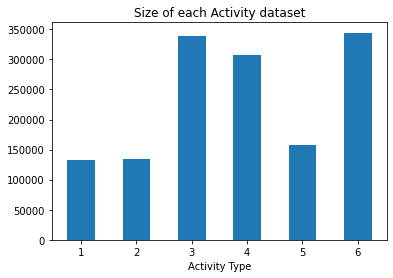

In [11]:
#@title
### class balance
class_counts = list()

for act in activity_types[:1]:
    class_counts.append(Df_all[Df_all['Activity']==activity_codes[act]].count())
plt.figure(1)
plt.title('Size of each Activity dataset')
plt.xlabel('Activity Type')
plt.hist(Df_all['Activity'],bins=range(1,8),rwidth=0.5,align='left')

print('Key: Activity 1 - downstairs, 2 - jogging, 3 - sitting, 4 - standing, 5 - upstairs, 6 - walking')     


Motion data comparison

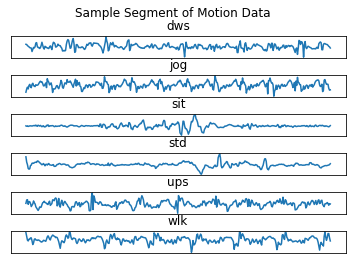

In [12]:
#@title
### show the first few records of motion type
plt.figure(3)
plt.suptitle(f'Sample Segment of Motion Data', fontsize=12)
colors = ['r','g','b','c','m','y','k']
for act in activity_types:
    plt.subplot('61'+str(activity_codes[act]))
    plt.subplots_adjust(hspace=0.75)
    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    plt.title(act)
    plt.plot(df['userAcceleration.z'][:400])
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels

###Hierachical clustering with dynamic time wrapping

Using the methods provided by library "dtaidistance.", 400 datapoints of each motion data (userAcceleration.z) by activity type are segmented and similiarity between each segment is calculated by dynamic time wrapping.


In [14]:
pip install dtaidistance

     |████████████████████████████████| 535 kB 29.7 MB/s 


In [15]:
from dtaidistance import dtw

In [16]:
from dtaidistance import clustering

In [21]:
import matplotlib.pyplot as plt

series_list = list()
labels_list = list()
for act in activity_types:

    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    series_list.append(df['userAcceleration.z'][:400])
    labels_list.extend([act])

series = np.array(series_list)
ds = dtw.distance_matrix_fast(series)

model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
model.fit(series)
model.plot(show_ts_label=labels_list,
           show_tr_label=True)

The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.


Exception: ignored

Based on hierachical clustering, 'dws', 'ups', 'wlk' are similar to each other, 'sit' and 'std' are similair, and 'jog' is distinctive from the other five.

###Summary

The class sizes for each activity type are not balanced due to the length of the trials and the variety of timescales taken by the participants to complete them. The jogging activity type is distinctively different from the other time series datasets, with downstairs, upstairs and walking having similarities and sitting and standing also.